In [1]:
%reload_ext autoreload
%autoreload 2

In [2]:
import pandas as pd
from fastai import *
from fastai.tabular import *
from fastai.callbacks import *
from fastai.text import *
from fastai.data_block import *
from fastai.metrics import *
from sklearn.model_selection import StratifiedKFold
import pickle
from fastprogress import master_bar, progress_bar
from IPython.display import FileLink
from sklearn.decomposition import PCA
import time
from swallows.training import *

In [3]:
pd.set_option('display.max_colwidth', -1)
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', 1000)

In [4]:
model_name = 'tab-v4-tuning-3-stage-4'

In [5]:
path=Path('data')

In [6]:
df_raw = pd.read_parquet(path/'processed/training_stage_4.parquet')
df_raw_test = pd.read_parquet(path/'processed/public_test_features_stage_4.parquet')

In [7]:
df_train = df_raw
df_test = df_raw_test

In [8]:
df_root_cause_counts = pd.DataFrame(df_raw.groupby(['root_cause']).size().sort_values(ascending=False), columns=['count'])

In [9]:
min_size = 500
large_cats = df_root_cause_counts[df_root_cause_counts["count"] > min_size]
total_count = int(df_root_cause_counts.sum())
total_big_enough_covered =float(large_cats.sum()*100/df_root_cause_counts.sum())
print(f'Total cats: {len(df_root_cause_counts)} with {total_count} items')
print(f'cats w/ >{min_size} items: {len(large_cats)} with {total_big_enough_covered:.2f}% coverage')

Total cats: 960 with 1156151 items
cats w/ >500 items: 81 with 97.40% coverage


# Simple tabular NN

In [10]:
cont_names = [] #['create_to_assigned_lag_log']

exclude_from_cats = [
    'ID', 
    'assigned_date',
    'create_date',
    'details',
    'short_description',
    'amazon_domains',
    'root_cause',
    'create_to_assigned_lag'
    'create_to_assigned_lag_log',
    'assigned_date_Elapsed'
    'create_date_Elapsed',
] + cont_names

cat_names = [c for c in df_raw.columns if c not in exclude_from_cats]
dep_var = 'root_cause'
procs = [FillMissing, Categorify, Normalize]

In [11]:
test = TabularList.from_df(df_test[cat_names + cont_names], path=path, cat_names=cat_names, cont_names=cont_names)

In [12]:
train_data = df_train[df_train['root_cause'].isin(large_cats.reset_index()['root_cause'])]
train_data = train_data[cat_names + cont_names + [dep_var]]

In [13]:
# splits_idxs = [s for s in gen_splits(10, train_data, 'root_cause')]
# pickle.dump(splits_idxs, open(path/f'{model_name}_cv_splits-10.pkl', "wb"))

In [14]:
splits_idxs = pickle.load(open(path/f'{model_name}_cv_splits-10.pkl', "rb"))
split = splits_idxs[7]

In [16]:
data = (TabularList.from_df(train_data, 
                            path=path, cat_names=cat_names, cont_names=cont_names, procs=procs)
                           .split_by_idxs(split[0], split[1])
                           .label_from_df(cols=dep_var)
                           .add_test(test)
                           .databunch(bs=1024))

In [18]:
learn = tabular_learner(data, layers=[727,353], metrics=accuracy)

In [ ]:
learn.lr_find(); learn.recorder.plot()

epoch,train_loss,valid_loss,accuracy,time
0,1.389827,1.426943,0.539644,01:34
1,1.366036,4.141174,0.452877,01:34
2,1.310915,1.345620,0.562018,01:34
3,1.258523,1.320551,0.568555,01:34
4,1.178045,1.302811,0.577268,01:34
5,1.089085,1.310574,0.581682,01:34
6,1.012411,1.338087,0.579826,01:34


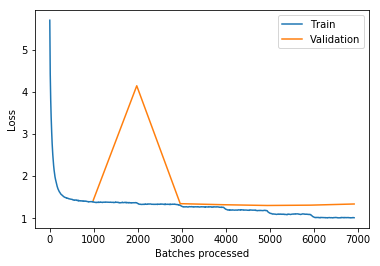

In [20]:
learn.fit_one_cycle(7, 1e-2); learn.recorder.plot_losses()

In [ ]:
# 582242  max seen in Tabular-Model-v4-727-353-Stage-4

In [21]:
learn.save(f'{model_name}-fitted')

### Predictions

In [34]:
preds,y = learn.get_preds(ds_type=DatasetType.Test)

In [35]:
pred_classes = [data.classes[cls] for cls in np.argmax(preds.numpy(), axis=1)]

In [36]:
df_out = pd.DataFrame({'ID': df_raw_test['ID'], 'root_cause': pred_classes})

In [37]:
t = time.strftime('%Y_%m_%d_%H_%M')
out_fname = path/f'mle_ops_tech_naive_{t}_{model_name}.csv'
df_out.to_csv(out_fname, index=False)
FileLink(out_fname)

/home/ec2-user/2019-ops-it-challenge/data/mle_ops_tech_naive_2019_04_27_05_42_tab-v4-tuning-3-stage-4.csv

* public leaderboard:  0.566779819735

### Interpretation

In [22]:
preds,y = learn.get_preds(ds_type=DatasetType.Valid)

In [23]:
pred_classes = [data.classes[cls] for cls in np.argmax(preds.numpy(), axis=1)]

In [29]:
df_val = df_raw.iloc[split[1]].copy()
df_val['root_cause_pred'] = pred_classes
df_val['match'] = df_val['root_cause'] == df_val['root_cause_pred']

In [34]:
t = time.strftime('%Y_%m_%d_%H_%M')
out_fname = path/f'mle_ops_tech_{t}_val_mimatches_exploration.csv'
df_val.to_csv(out_fname, index=False)
FileLink(out_fname)

/home/ec2-user/2019-ops-it-challenge/data/mle_ops_tech_2019_04_30_16_45_val_mimatches_exploration.csv

In [31]:
interp = ClassificationInterpretation.from_learner(learn)

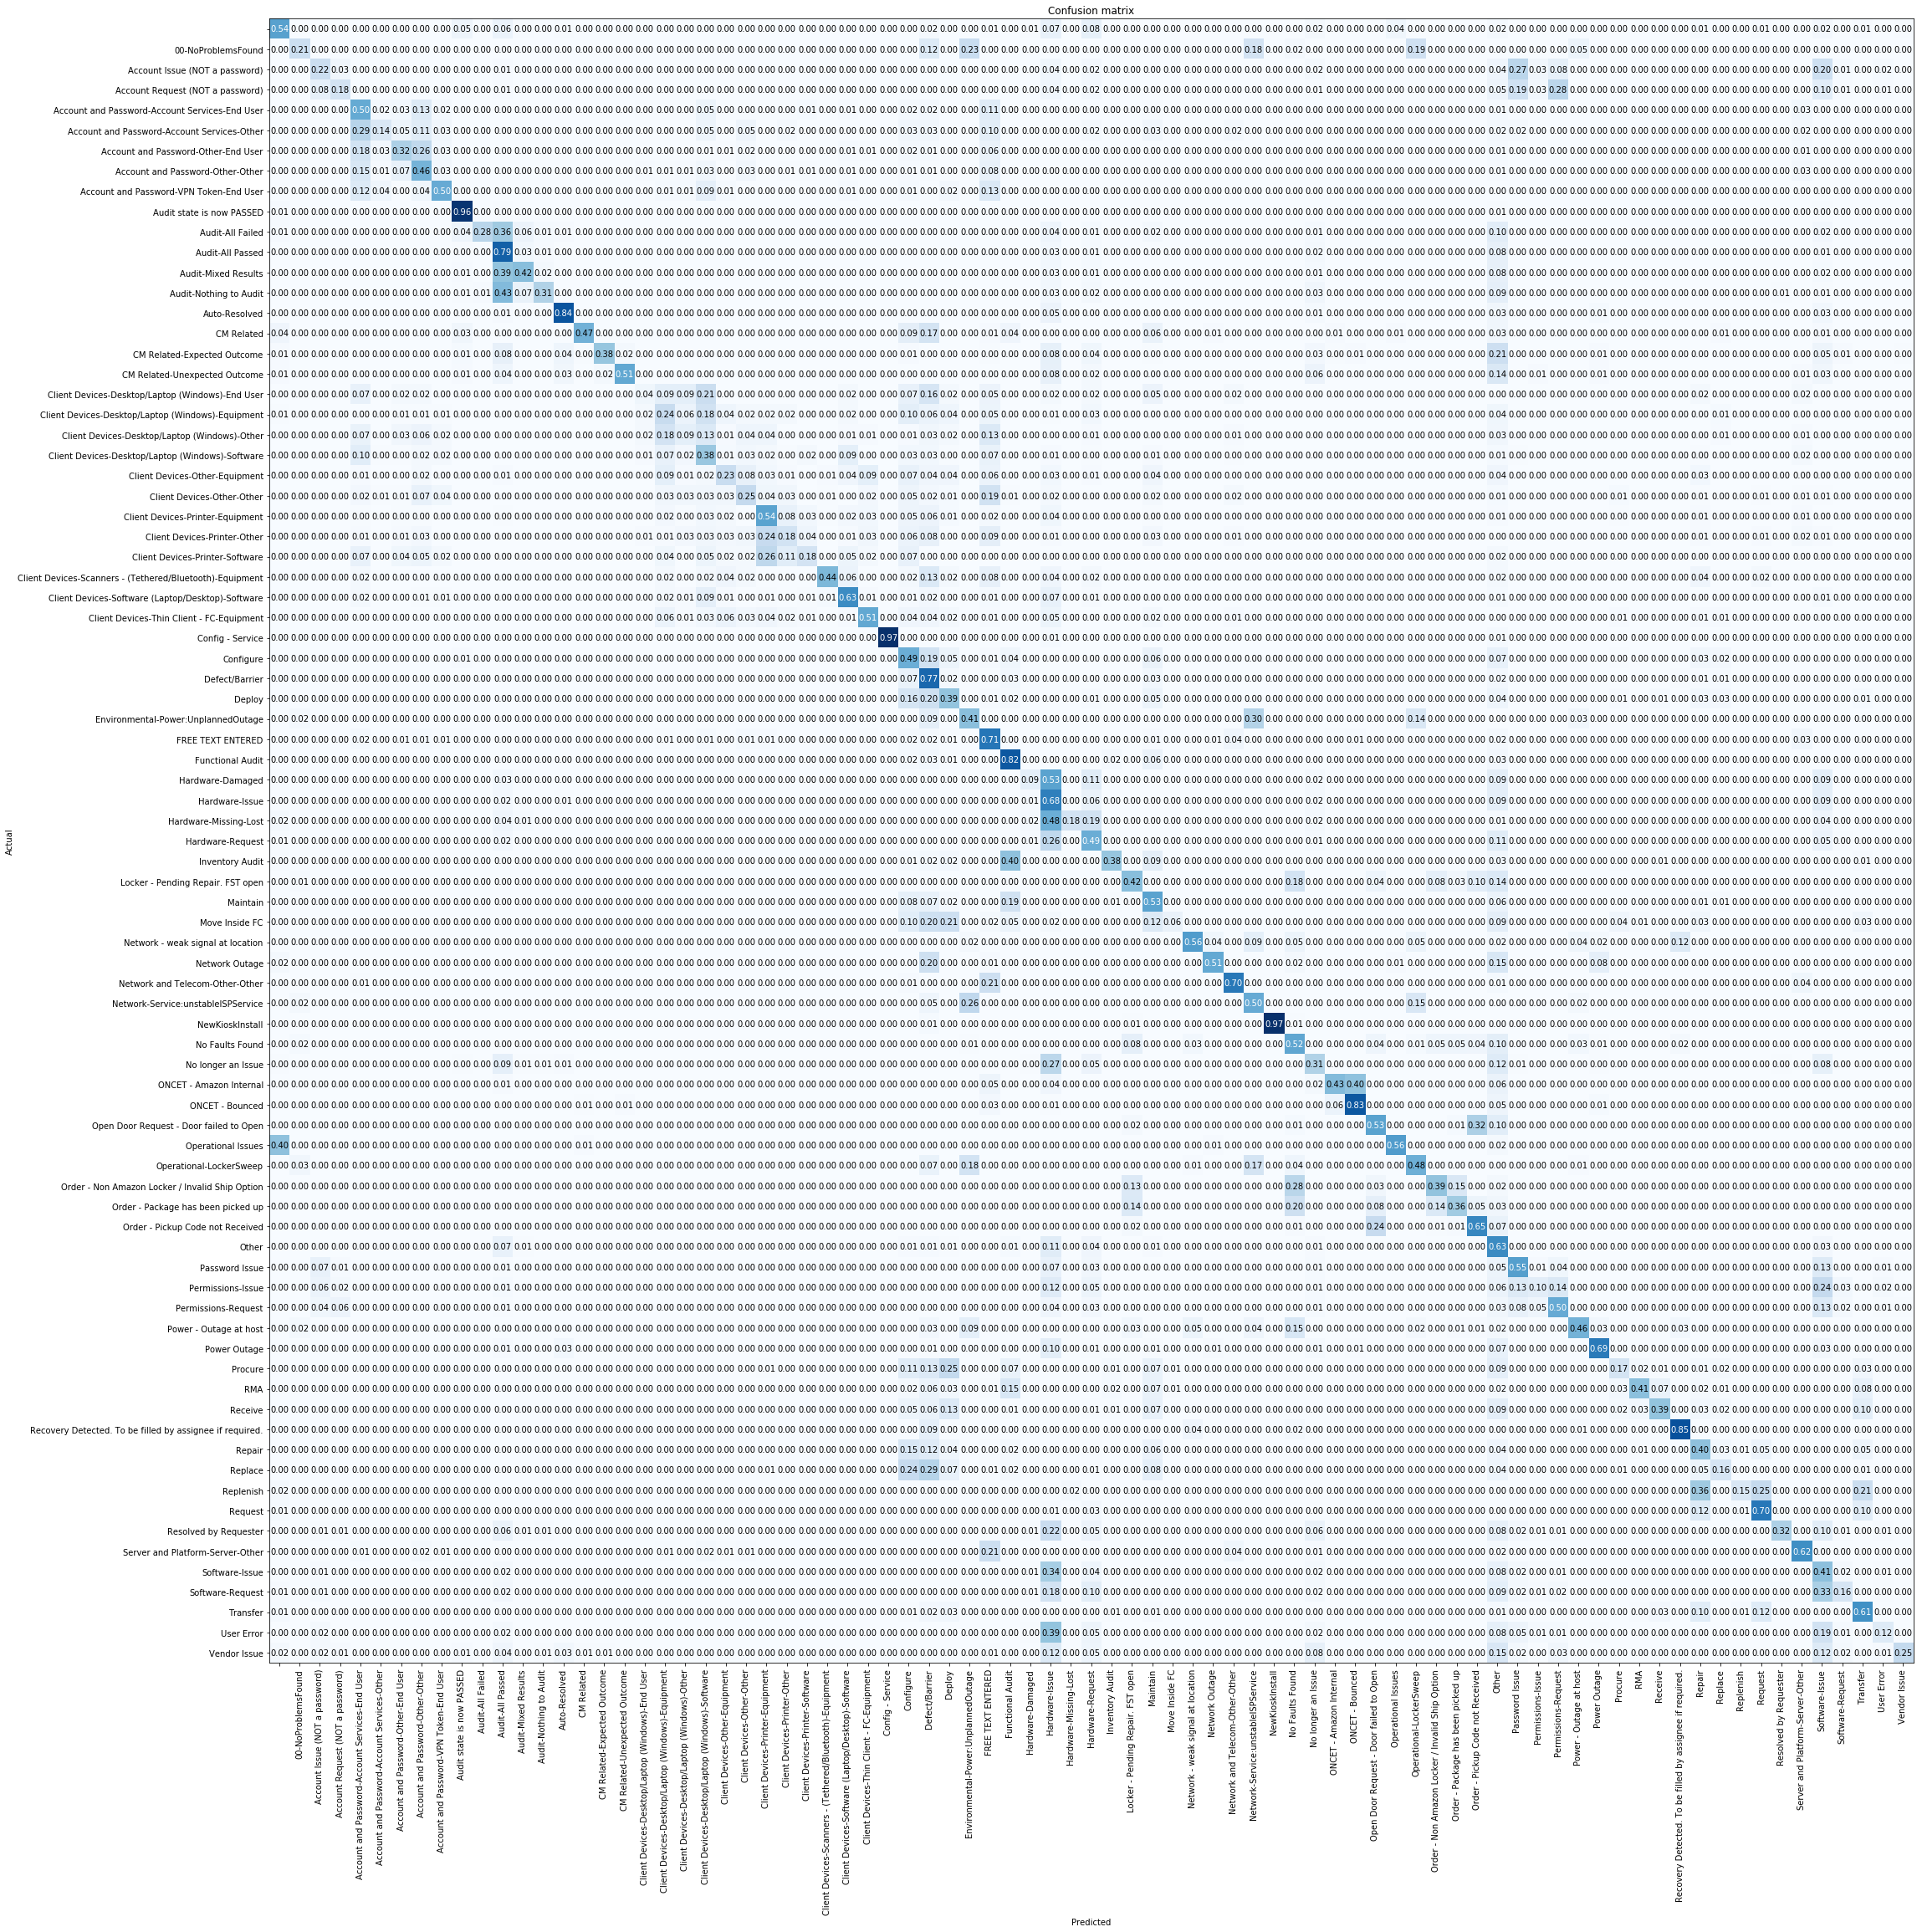

In [32]:
interp.plot_confusion_matrix(figsize=(32,32), normalize=True)

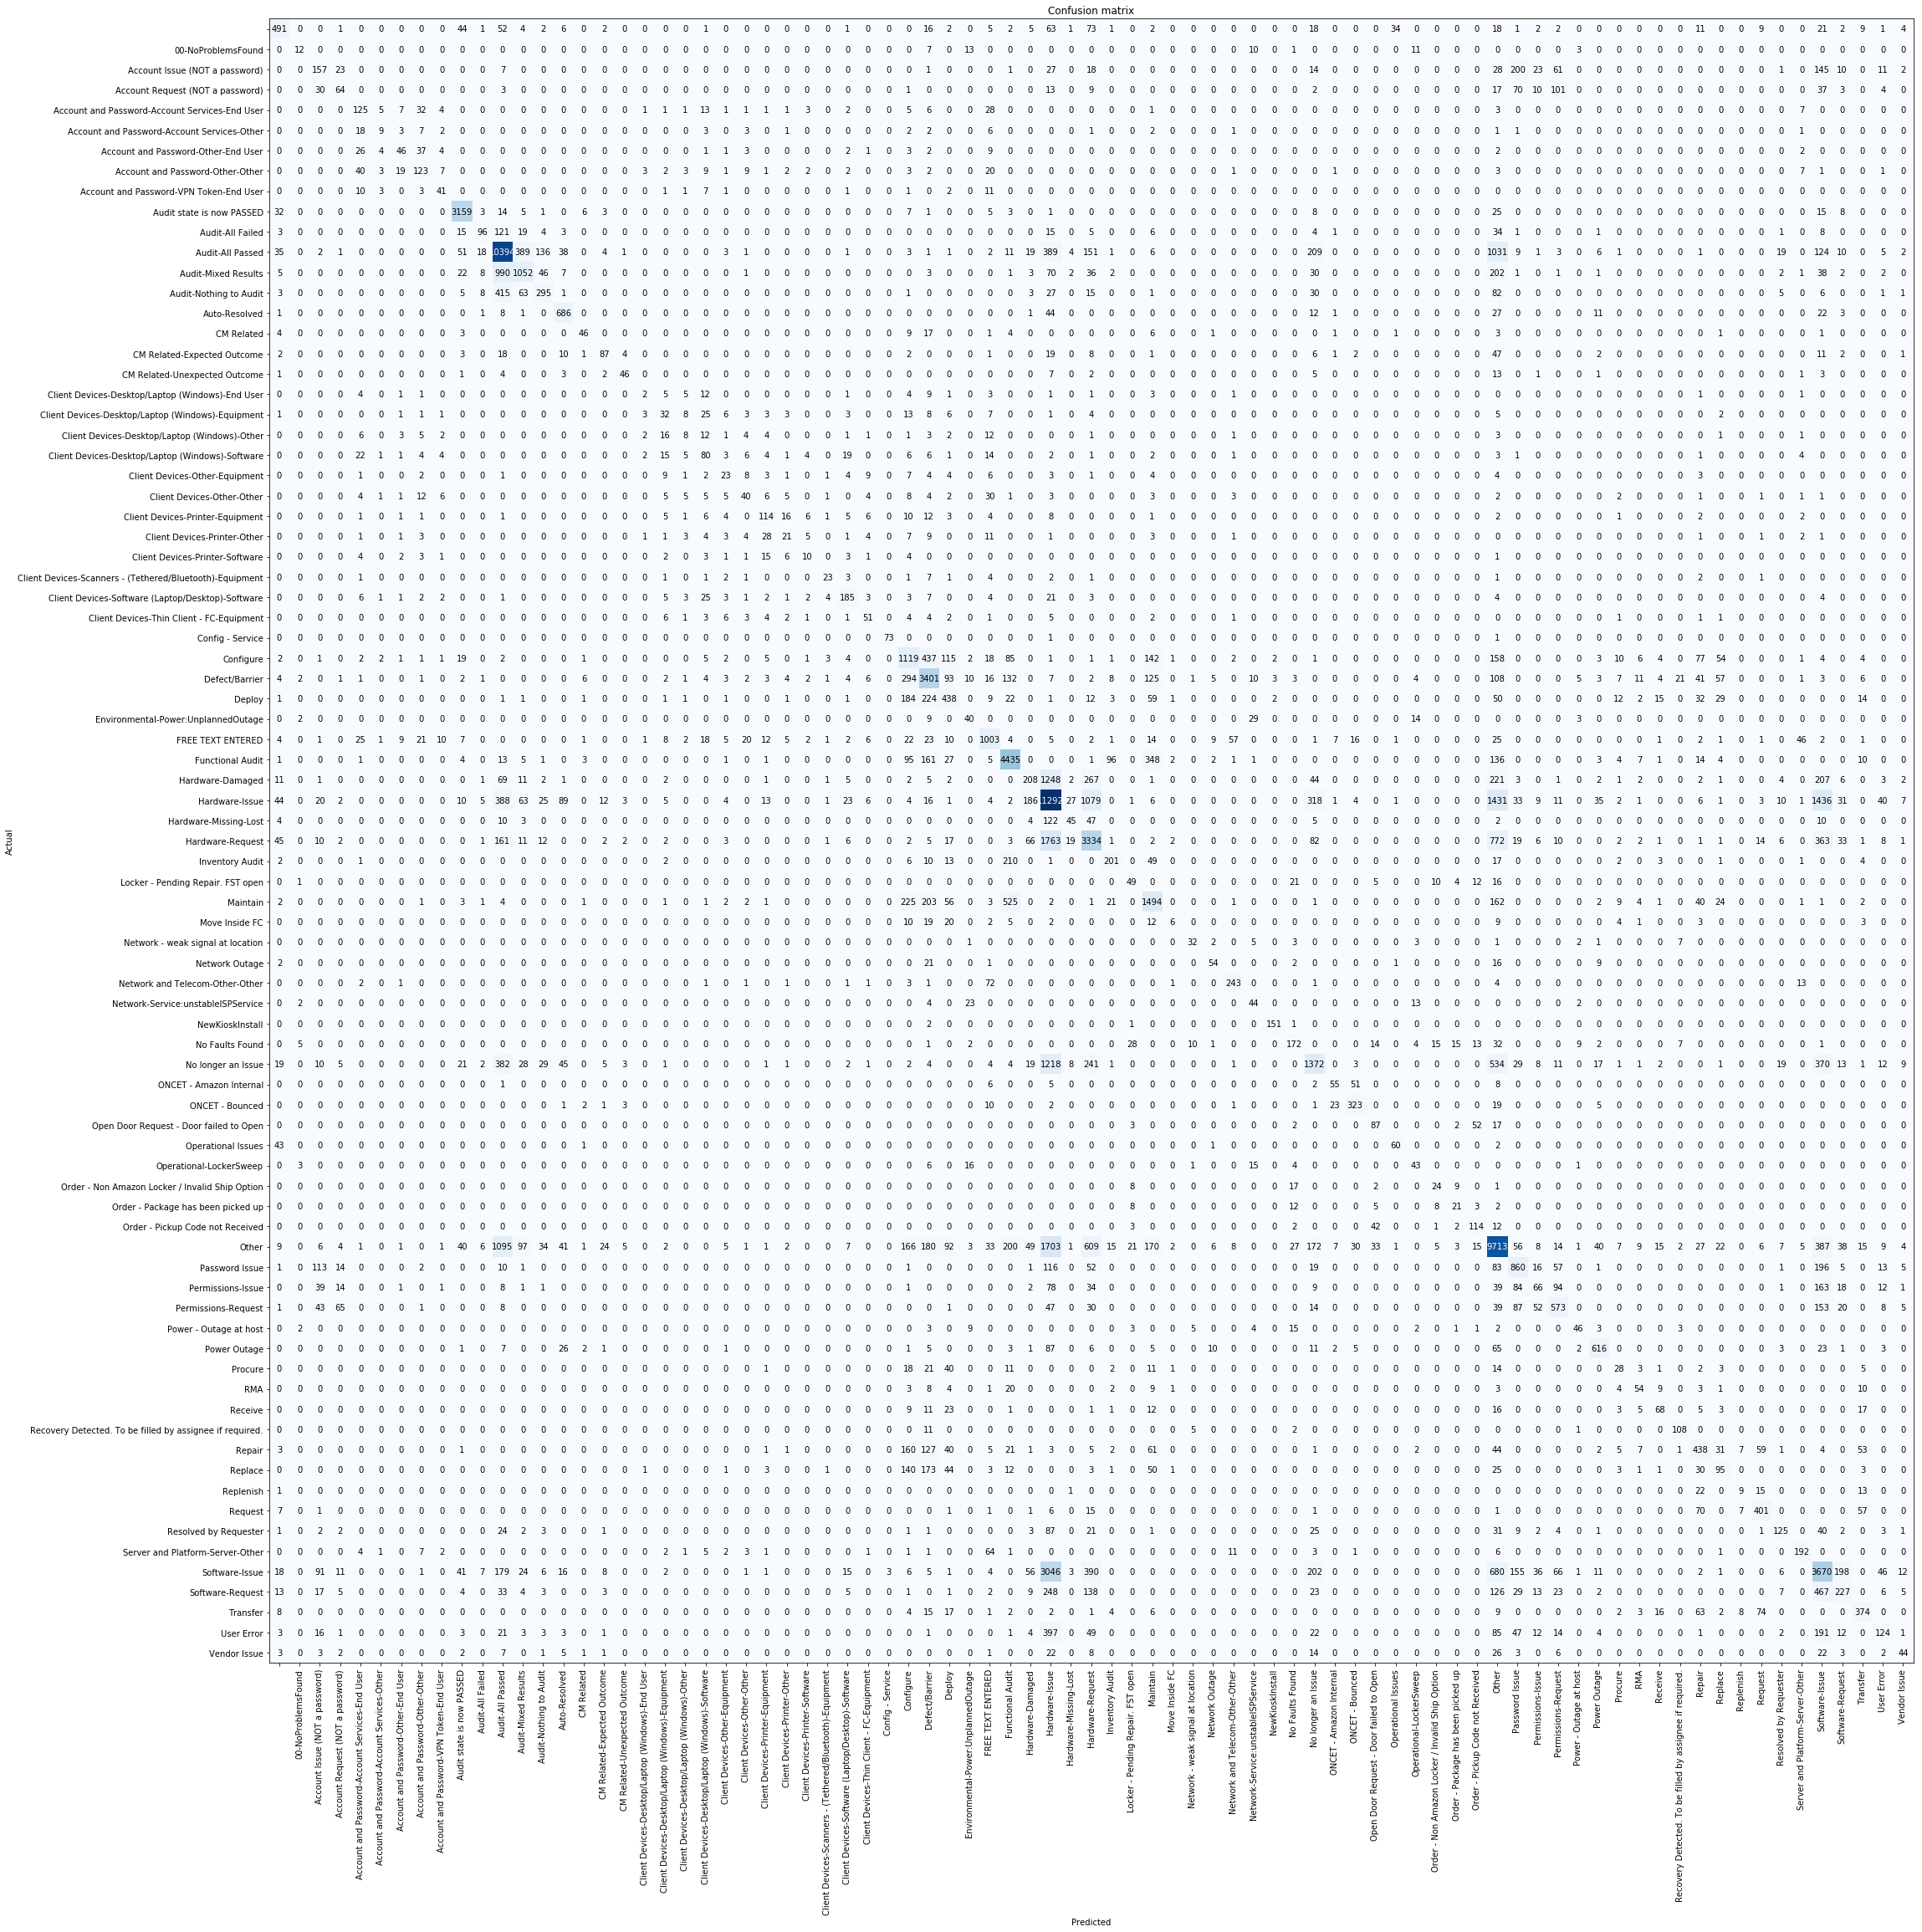

In [33]:
interp.plot_confusion_matrix(figsize=(32,32))